In [1]:
import pandas as pd
import os

In [2]:
# conda install -c conda-forge seaborn
import seaborn as sns

In [3]:
data_path = r"../data/original/DWD/annual/kl/historical/"
station_file_name = r"KL_Jahreswerte_Beschreibung_Stationen.txt"

#print(f"Data Path: {data_path:s}") 

In [4]:
full_fname = data_path + station_file_name
print(full_fname)

../data/original/DWD/annual/kl/historical/KL_Jahreswerte_Beschreibung_Stationen.txt


In [5]:
#fh = open(full_fanme)
headers = open(full_fname).readline().split()
df_stat = pd.read_fwf(
    full_fname,
    encoding="cp1252",
    skiprows=2,
    names=headers,
    index_col="Stations_id", 
    parse_dates=["von_datum","bis_datum"])

In [6]:
idx_NRW    = df_stat["Bundesland"] == "Nordrhein-Westfalen"
idx_active = df_stat["bis_datum"]  == "2020-12-31"
idx_early  = df_stat["von_datum"]   < "1930"

In [7]:
df_stat_short = df_stat[idx_NRW & idx_active & idx_early]

In [8]:
df_stat_short

,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
Stations_id,,,,,,,
1303,1888-01-01,2020-12-31,150,51.4041,6.9677,Essen-Bredeney,Nordrhein-Westfalen
2483,1926-11-01,2020-12-31,839,51.1803,8.4891,Kahler Asten,Nordrhein-Westfalen
2629,1851-01-01,2020-12-31,46,51.7612,6.0954,Kleve,Nordrhein-Westfalen
2968,1903-01-01,2020-12-31,43,50.9894,6.9777,Köln-Stammheim,Nordrhein-Westfalen
5717,1907-01-01,2020-12-31,134,51.2256,7.1052,Wuppertal-Buchenhofen,Nordrhein-Westfalen


In [9]:
fname_list = os.listdir(data_path)

In [10]:
f_dict={}

for fname in fname_list:
    try:
        key=fname.split("_")[2]
        f_dict[int(key)]=fname
    except:
        print(f"Cannot convert \'{key:s}\' to integer")

n=5
print("Frist {n:d} items of f_dict:")
print({k: f_dict[k] for k in list(f_dict)[:5]})


Cannot convert 'Beschreibung' to integer
Frist {n:d} items of f_dict:
{1: 'jahreswerte_KL_00001_19310101_19851231_hist.zip', 3: 'jahreswerte_KL_00003_18510101_20110331_hist.zip', 44: 'jahreswerte_KL_00044_19710301_20201231_hist.zip', 52: 'jahreswerte_KL_00052_19730101_20011231_hist.zip', 61: 'jahreswerte_KL_00061_19760101_19771231_hist.zip'}


In [11]:
zip_list=[]
for k in df_stat_short.index:
    zip_list.append(data_path + f_dict[k])

In [12]:
# MORE ELEGANT!
zip_list = [data_path + f_dict[k] for k in df_stat_short.index]

In [13]:
zip_list

['../data/original/DWD/annual/kl/historical/jahreswerte_KL_01303_18880101_20201231_hist.zip',
 '../data/original/DWD/annual/kl/historical/jahreswerte_KL_02483_19290101_20201231_hist.zip',
 '../data/original/DWD/annual/kl/historical/jahreswerte_KL_02629_18510101_20201231_hist.zip',
 '../data/original/DWD/annual/kl/historical/jahreswerte_KL_02968_19030101_20201231_hist.zip',
 '../data/original/DWD/annual/kl/historical/jahreswerte_KL_05717_19070101_20201231_hist.zip']

In [14]:
import pandas as pd
from zipfile import ZipFile

# Very compact code.
df = pd.DataFrame()
for elt in zip_list:
    with ZipFile(elt) as myzip:
        
        # read the time series data from the file starting with "produkt"
        prodfilename = [name for name in myzip.namelist() if name.split("_")[0]=="produkt"][0] 
        #print(prodfilename)
        
        # open just the produkt file within the archive
        with myzip.open(prodfilename) as myfile:
            dftmp = pd.read_csv(myfile, sep =";", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], index_col = "MESS_DATUM_BEGINN", na_values = [-999.0])
            # select the series with the average annual temp ("JA_TT"), rename the series with the station_id and make it a df.
            s = dftmp["JA_TT"].rename(dftmp["STATIONS_ID"][0]).to_frame()
            # outer merge.
            df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

#df.index.names = ["year"]
df.index.rename(name = "year", inplace = True)
df

,1303,2483,2629,2968,5717
year,,,,,
1851-01-01,NaN,NaN,8.73,NaN,NaN
1852-01-01,NaN,NaN,9.90,NaN,NaN
1853-01-01,NaN,NaN,7.89,NaN,NaN
1854-01-01,NaN,NaN,9.09,NaN,NaN
1855-01-01,NaN,NaN,7.34,NaN,NaN
...,...,...,...,...,...
2016-01-01,10.77,6.16,10.59,11.64,10.41
2017-01-01,10.92,6.26,NaN,11.92,10.66
2018-01-01,11.79,7.26,NaN,12.67,NaN


In [15]:
# Replace full datetime with year as integer
df.set_index(df.index.year, inplace= True) # extract year from index as int

In [16]:
df.head()

,1303,2483,2629,2968,5717
year,,,,,
1851,NaN,NaN,8.73,NaN,NaN
1852,NaN,NaN,9.90,NaN,NaN
1853,NaN,NaN,7.89,NaN,NaN
1854,NaN,NaN,9.09,NaN,NaN
1855,NaN,NaN,7.34,NaN,NaN


In [17]:
mean = df[(df.index >= 1961) & (df.index <= 1990)].mean() # mean annual temp between 1961 and 1990
mean

1303     9.560667
2483     4.847333
2629     9.613000
2968    10.780000
5717     9.335333
dtype: float64

In [18]:
df_temp_diff = (df - mean)

In [19]:
df_temp_diff

,1303,2483,2629,2968,5717
year,,,,,
1851,NaN,NaN,-0.883,NaN,NaN
1852,NaN,NaN,0.287,NaN,NaN
1853,NaN,NaN,-1.723,NaN,NaN
1854,NaN,NaN,-0.523,NaN,NaN
1855,NaN,NaN,-2.273,NaN,NaN
...,...,...,...,...,...
2016,1.209333,1.312667,0.977,0.86,1.074667
2017,1.359333,1.412667,NaN,1.14,1.324667
2018,2.229333,2.412667,NaN,1.89,NaN


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline

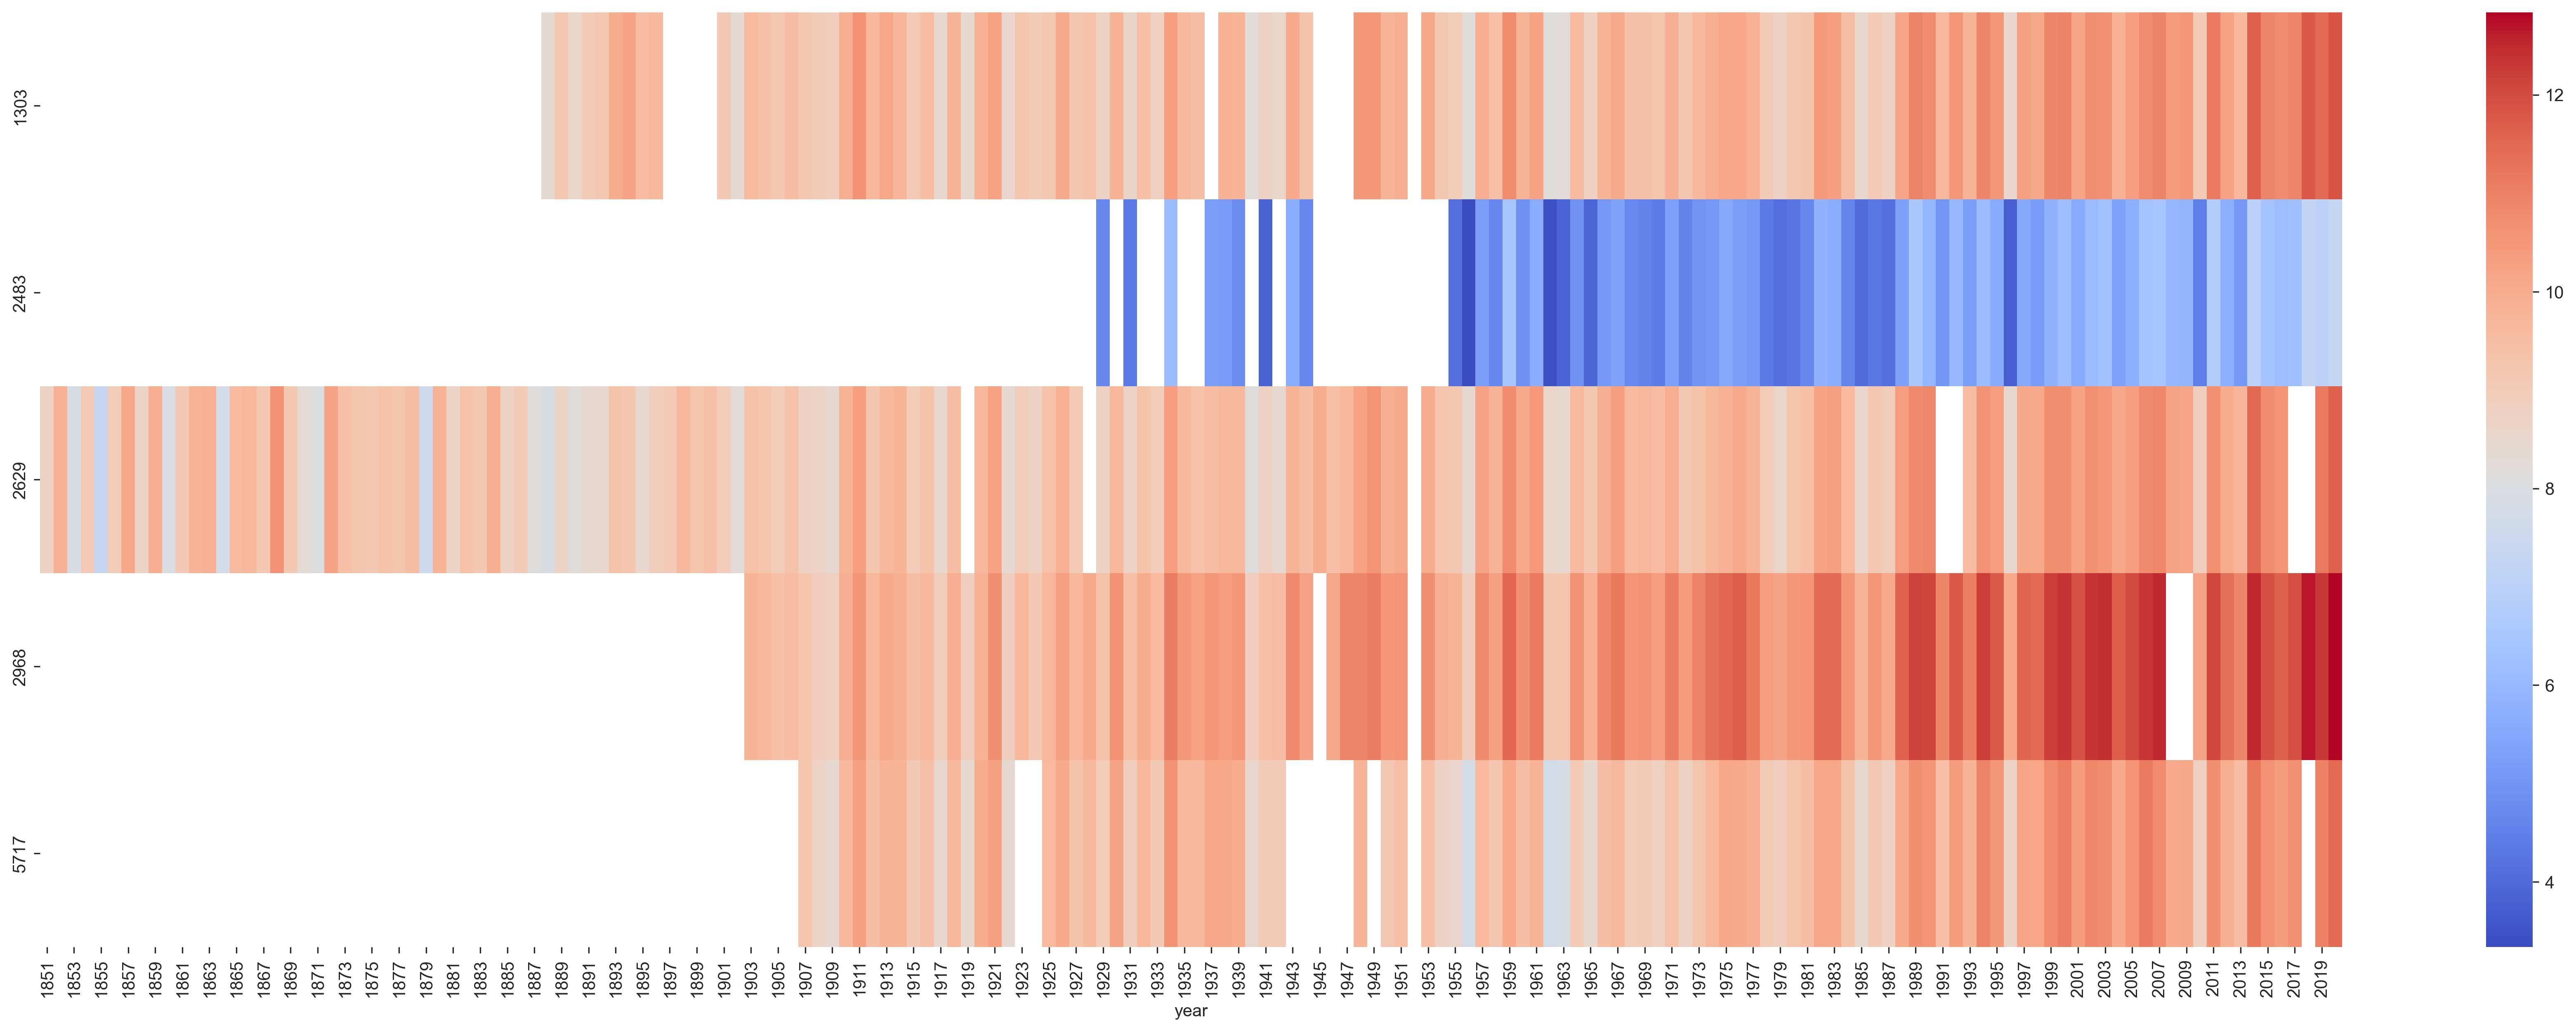

In [21]:
# plot
sns.set_style('ticks')
fig1, ax1 = plt.subplots(dpi = 300, figsize = (30,10))

# sns.heatmap(df_temp_diff.T, cmap='coolwarm', vmin = -2, vmax = 2, ax = ax4)
sns.heatmap(df.T, cmap='coolwarm', ax = ax1)

fig1.savefig('NRW_Annual_Temp_Stripes_01.png')


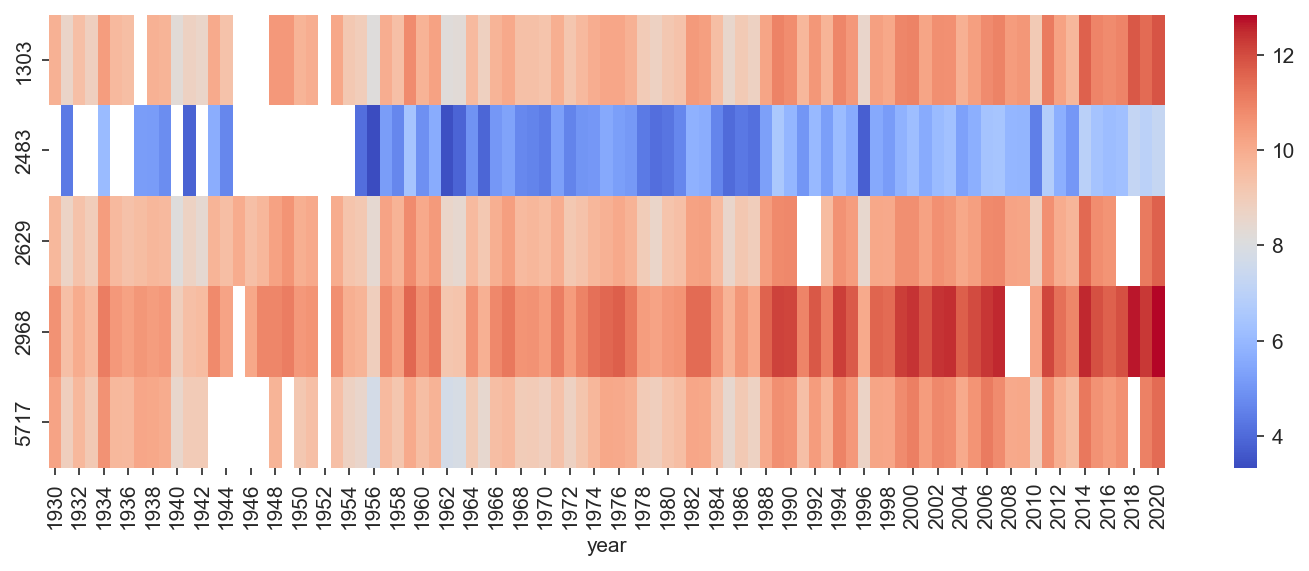

In [22]:
# plot
sns.set_style('ticks')
fig2, ax2 = plt.subplots(dpi = 150, figsize = (12,4))

#sns.heatmap(df_tdiff, cmap='coolwarm', annot=True, vmin = -2, vmax = 2, ax = ax3)
sns.heatmap(df[df.index >= 1930].T, cmap='coolwarm', ax = ax2)
#ax4.set_xticklabels(df.index.strftime('%Y'))

fig2.savefig('NRW_Annual_Temp_Stripes_02.png')

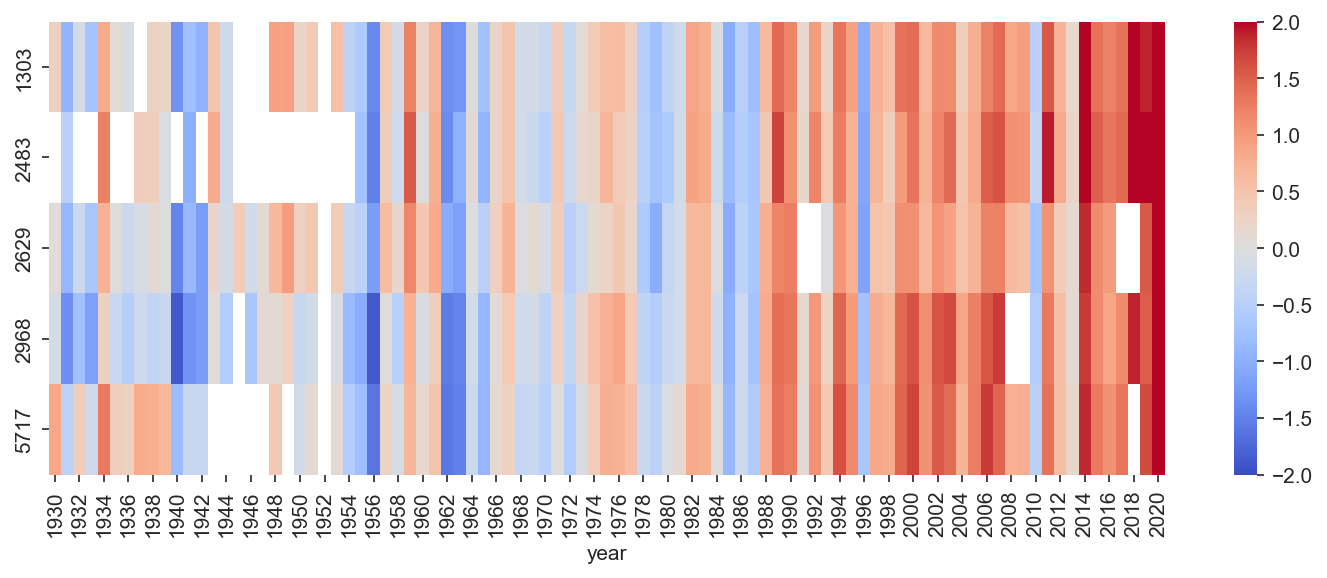

In [23]:
# plot
sns.set_style('ticks')
fig3, ax3 = plt.subplots(dpi = 150, figsize = (12,4))

#sns.heatmap(df_tdiff, cmap='coolwarm', annot=True, vmin = -2, vmax = 2, ax = ax3)
sns.heatmap(df_temp_diff[df_temp_diff.index >= 1930].T, cmap='coolwarm', vmin = -2, vmax = 2, ax = ax3)
#ax4.set_xticklabels(df.index.strftime('%Y'))

fig3.savefig('NRW_Annual_Temp_Diff_Stripes_02.png')

In [24]:
df_stat_short["Stationsname"]

Stations_id
1303           Essen-Bredeney
2483             Kahler Asten
2629                    Kleve
2968           Köln-Stammheim
5717    Wuppertal-Buchenhofen
Name: Stationsname, dtype: object

In [25]:
df_stat_short["von_datum"]

Stations_id
1303   1888-01-01
2483   1926-11-01
2629   1851-01-01
2968   1903-01-01
5717   1907-01-01
Name: von_datum, dtype: datetime64[ns]

In [26]:
df.head()

,1303,2483,2629,2968,5717
year,,,,,
1851,NaN,NaN,8.73,NaN,NaN
1852,NaN,NaN,9.90,NaN,NaN
1853,NaN,NaN,7.89,NaN,NaN
1854,NaN,NaN,9.09,NaN,NaN
1855,NaN,NaN,7.34,NaN,NaN
